In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import re
import string
# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB

In [11]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\vaish\appdata\local\temp\pip-req-build-gdyj6rjt
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\vaish\AppData\Local\Temp\pip-req-build-gdyj6rjt'
You should consider upgrading via the 'c:\users\vaish\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
df=pd.read_csv("TwitterHate.csv")
df.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

In [15]:
import preprocess_kgptalkie as ps
def clean_text_round1(text):
    text = ps.cont_exp(text)
    text = ps.remove_emails(text)
    text = ps.remove_html_tags(text)
    text = ps.remove_accented_chars(text)
    text = ps.remove_special_chars(text)
    text = re.sub("(.)\\1{2,}", "\\1", text)
    '''Make text lowercase, remove punctuation, mentions, hashtags and words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)
    return text

In [16]:
# tokenizing and removing stop words
def process_tweet(text):
    """tokenize text in each column and remove stop words"""
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [17]:
df['tweet'] = df['tweet'].apply(lambda x: clean_text_round1(x))

##Censoring Words

In [18]:
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n***a', 'nigger':'ni**er', 'ass':'a**', 'hoe':'h**', 'hoes':'h**s', 'faggot':'fa***t', 'faggots':'fa***ts', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f**', 'shit':'sh*t' }

for k, v in replacements.items():
    df['tweet'] = df['tweet'].str.replace(k, v)

In [19]:
df.head()

id  label                                              tweet
0   1      0  when a father is dysfunctional and is so selfi...
1   2      0  thanks for credit i cant use cause they dont o...
2   3      0                                bihday your majesty
3   4      0        i love you take with you all the time in ur
4   5      0                             factsguide society now

# Most Frequent Words for Each Classification

In [20]:
clean_df = df
clean_df

id  label                                              tweet
0          1      0  when a father is dysfunctional and is so selfi...
1          2      0  thanks for credit i cant use cause they dont o...
2          3      0                                bihday your majesty
3          4      0        i love you take with you all the time in ur
4          5      0                             factsguide society now
...      ...    ...                                                ...
31957  31958      0                                 ate isz that youai
31958  31959      0  to see nina turner on the airwaves trying to w...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1                      vandalised in in condemns act
31961  31962      0                           thank you for you follow

[31962 rows x 3 columns]

In [21]:
# creating new dfs for each classification
df_freq_hate = clean_df[clean_df['label']==1]
df_freq_not_hate = clean_df[clean_df['label']==0]

In [22]:
# pulling out the text data for cleaned tweets
data_hate = df_freq_hate['tweet']
data_not_hate = df_freq_not_hate['tweet']

In [23]:
# creating lists for processed hate & not hate data
process_hate = list(map(process_tweet, data_hate))
process_not_hate = list(map(process_tweet, data_not_hate))

In [24]:
# exact amount of hate speech
total_vocab_hate = set()
for comment in process_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

4512

In [25]:
# exact amount of not hate speech
total_vocab_NOT_hate = set()
for comment in process_not_hate:
    total_vocab_NOT_hate.update(comment)
len(total_vocab_NOT_hate)

21256

# Most Common Words in Each Category

In [26]:
flat_hate = [item for sublist in process_hate for item in sublist]
flat_not_hate = [item for sublist in process_not_hate for item in sublist]

In [27]:
hate_freq = FreqDist(flat_hate)
not_hate_freq = FreqDist(flat_not_hate)

In [28]:
# Top 20 Hate Speech words:
hate_freq.most_common(20)

[('like', 136),
 ('white', 124),
 ('racist', 102),
 ('people', 90),
 ('black', 87),
 ('might', 77),
 ('libtard', 73),
 ('trump', 72),
 ('dont', 65),
 ('new', 65),
 ('racism', 64),
 ('women', 61),
 ('feel', 59),
 ('listen', 57),
 ('one', 48),
 ('stomping', 48),
 ('us', 46),
 ('im', 45),
 ('via', 43),
 ('obama', 42)]

In [29]:
not_hate_freq.most_common(20)

[('day', 1994),
 ('happy', 1550),
 ('love', 1189),
 ('im', 1088),
 ('time', 1068),
 ('today', 958),
 ('get', 879),
 ('new', 870),
 ('ai', 868),
 ('like', 833),
 ('people', 802),
 ('cant', 762),
 ('good', 755),
 ('see', 741),
 ('one', 725),
 ('life', 694),
 ('dont', 646),
 ('go', 624),
 ('want', 621),
 ('take', 599)]

In [30]:
# Normalizing Word Frequencies

In [31]:
hate_total_word_count = sum(hate_freq.values())
hate_top_25 = hate_freq.most_common(25)
print("Hate Word \t Normalized Frequency")
print()
for word in hate_top_25:
    normalized_frequency = word[1]/hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Hate Word 	 Normalized Frequency

like 		 0.01019
white 		 0.009288
racist 		 0.00764
people 		 0.006742
black 		 0.006517
might 		 0.005768
libtard 		 0.005468
trump 		 0.005393
dont 		 0.004869
new 		 0.004869
racism 		 0.004794
women 		 0.004569
feel 		 0.004419
listen 		 0.00427
one 		 0.003596
stomping 		 0.003596
us 		 0.003446
im 		 0.003371
via 		 0.003221
obama 		 0.003146
would 		 0.002921
woman 		 0.002846
cant 		 0.002697
comments 		 0.002697
hate 		 0.002622


In [32]:
not_hate_total_word_count = sum(not_hate_freq.values())
not_hate_top_25 = not_hate_freq.most_common(25)
print("Not Hate Word \t Normalized Frequency")
print()
for word in not_hate_top_25:
    normalized_frequency = word[1]/not_hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Not Hate Word 	 Normalized Frequency

day 		 0.0125
happy 		 0.009714
love 		 0.007451
im 		 0.006818
time 		 0.006693
today 		 0.006004
get 		 0.005509
new 		 0.005452
ai 		 0.00544
like 		 0.00522
people 		 0.005026
cant 		 0.004775
good 		 0.004732
see 		 0.004644
one 		 0.004544
life 		 0.004349
dont 		 0.004048
go 		 0.003911
want 		 0.003892
take 		 0.003754
fathers 		 0.003666
bihday 		 0.003572
got 		 0.003466
make 		 0.003221
bull 		 0.003159


# Visualizing Top Word Percentages

In [34]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_freq.most_common(20)]
hate_bar_words = [x[0] for x in hate_freq.most_common(20)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(20)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(20)]

In [35]:
# set the color of the bar graphs
color = cm.magma(np.linspace(.4,.8, 30))

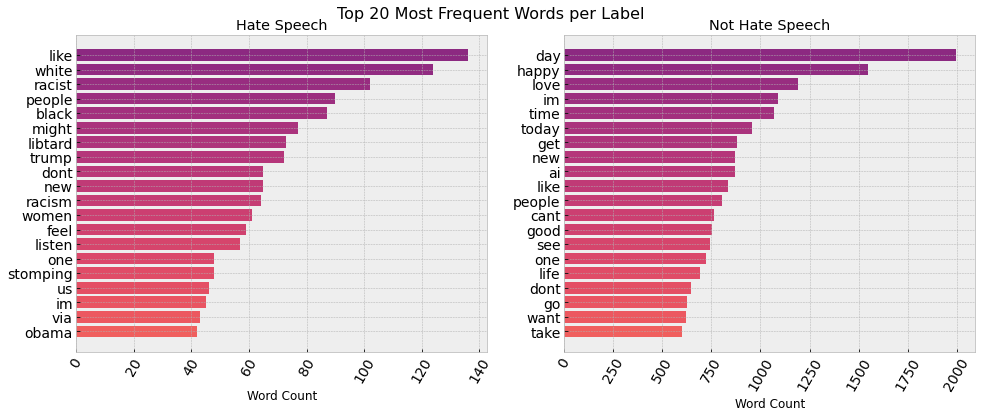

In [38]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# generating a bar chart on each axes
ax.barh(hate_bar_words, hate_bar_counts, color=color)
ax2.barh(not_hate_bar_words, not_hate_bar_counts, color=color)

ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

plt.savefig('./visualizations/label_word_count_y.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

# What Words are Only in Hate Speech?

In [40]:
def returnNotMatches(a, b):
    return [x for x in a if x not in b]

In [41]:
returnNotMatches(flat_hate, flat_not_hate)

['chant',
 'lumpy',
 'lumpy',
 'blk',
 'folx',
 'insecurity',
 'bringsa',
 'wonthey',
 'fuhered',
 'vota',
 'africanamerican',
 'cochair',
 'nonsensical',
 'boosa',
 'nazis',
 'studied',
 'originated',
 'arude',
 'critiquing',
 'stereotype',
 'codeword',
 'antiwhite',
 'everyona',
 'consent',
 'decree',
 'slogan',
 'bluntly',
 'thissuppoing',
 'openly',
 'wsmallgirlsexcom',
 'obsidian',
 'overwhelming',
 'echs',
 'carolyn',
 'americad',
 'oveurning',
 'aryans',
 'vps',
 'multimillion',
 'bonuses',
 'advancement',
 'oft',
 'tendencies',
 'professor',
 'aumptions',
 'jewsa',
 'retard',
 'wonthey',
 'fuhered',
 'seller',
 'sexist',
 'attracted',
 'attracted',
 'defines',
 'radicalism',
 'countered',
 'inhumans',
 'colora',
 'donkey',
 'palestinian',
 'semitic',
 'calla',
 'sympathisers',
 'familybut',
 'incessant',
 'veiled',
 'intent',
 'impoed',
 'investigate',
 'prosecute',
 'coopting',
 'autocorrects',
 'qualify',
 'decolonizing',
 'profitable',
 'homoresistanta',
 'yella',
 'pissedof

# Visualizing Unique Words with Venn Diagram

In [46]:
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

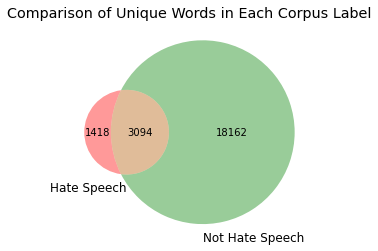

In [48]:
venn2([set(flat_hate), set(flat_not_hate)], set_labels = ('Hate Speech', 'Not Hate Speech'))
plt.title('Comparison of Unique Words in Each Corpus Label')
plt.savefig('./visualizations/word_venn.png', bbox_inches = "tight", pad_inches=.5)

# Word Clouds

In [49]:
from wordcloud import WordCloud
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

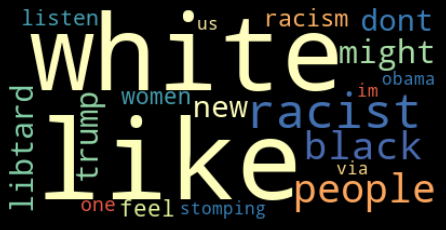

In [50]:
# create the word cloud:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(hate_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

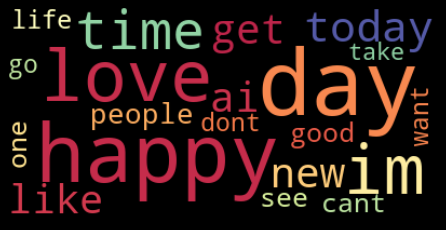

In [51]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_hate_dict)

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

# Tweet Cloud of Most Frequent Words in Corpus

In [53]:
tweet_df = clean_df[['tweet', 'label']].copy()

In [54]:
tweet_df.to_csv('./corpus.txt', sep='\t')

In [56]:
import stylecloud
stylecloud.gen_stylecloud(file_path = './corpus.txt', icon_name= 'fab fa-twitter', collocations=False, output_name = "./visualizations/stylecloud.png")

In [57]:
clean_df.head(3)

id  label                                              tweet
0   1      0  when a father is dysfunctional and is so selfi...
1   2      0  thanks for credit i cant use cause they dont o...
2   3      0                                bihday your majesty

In [62]:
raw_df = pd.read_csv("TwitterHate.csv")
raw_df

id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]

In [63]:
raw_df['hashtags'] = raw_df['tweet'].str.extract('([^&]#[\w]+)', expand=False).str.strip()

In [64]:
raw_df

id  label                                              tweet  \
0          1      0   @user when a father is dysfunctional and is s...   
1          2      0  @user @user thanks for #lyft credit i can't us...   
2          3      0                                bihday your majesty   
3          4      0  #model   i love u take with u all the time in ...   
4          5      0             factsguide: society now    #motivation   
...      ...    ...                                                ...   
31957  31958      0  ate @user isz that youuu?ðððððð...   
31958  31959      0    to see nina turner on the airwaves trying to...   
31959  31960      0  listening to sad songs on a monday morning otw...   
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...   
31961  31962      0                   thank you @user for you follow     

          hashtags  
0             #run  
1            #lyft  
2              NaN  
3              NaN  
4      #motivation  
...            ...  
31957          NaN  
31958       #shame  
31959          NaN  
31960        #sikh  
31961          NaN  

[31962 rows x 4 columns]

In [65]:
raw_df.shape

(31962, 4)

In [66]:
raw_df.hashtags.isna().sum()

9691

In [67]:
# dropping tweet rows with no hashtags
raw_df.dropna(inplace=True)

In [68]:
raw_df.shape

(22271, 4)

In [69]:
raw_df.reset_index(inplace=True)

# New Dataframe with Essential Columns

In [70]:
hashtags_df = raw_df[['label', 'hashtags']].copy()

In [71]:
hashtags_df.head()

label         hashtags
0      0             #run
1      0            #lyft
2      0      #motivation
3      0  #allshowandnogo
4      0          #school

## Round 2 Cleaning

In [72]:
hashtags_df['hashtags_2'] = hashtags_df['hashtags'].str.extract('(#[\w]+)', expand=False).str.strip()

In [73]:
hashtags_df.head()

label         hashtags       hashtags_2
0      0             #run             #run
1      0            #lyft            #lyft
2      0      #motivation      #motivation
3      0  #allshowandnogo  #allshowandnogo
4      0          #school          #school

In [74]:
# # iteratiively censoring words
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('faggots','f**gots')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('faggot','f**got')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('shittmybosssays','s**tmybosssays')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('hesgay','hesg*y')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('pussy','p**sy')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('bitch','b**ch')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('redskins','r**skins')
# hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('hoe','h*e')

In [75]:
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n***a', 'nigger':'ni**er', 'ass':'a**', 'hoe':'h**', 'hoes':'h**s', 'faggot':'fa***t', 'faggots':'fa***ts', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f**', 'shit':'sh*t', 'hesgay':'hesg*y','redskins':'r**skins',}

for k, v in replacements.items():
    hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace(k, v)

# Top Hashtags for Each Category

In [77]:
# creating new dfs for each classification
# hate speech
df_freq_hate = hashtags_df[hashtags_df['label']==1]
# not hate speech
df_freq_not_hate = hashtags_df[hashtags_df['label']==0]

In [78]:
# pulling out the hashtags column for raw tweets
hashtag_hate = df_freq_hate['hashtags_2']
hashtag_not_hate = df_freq_not_hate['hashtags_2']

In [79]:
# exact amount of hashtags in hate speech
total_vocab_hate = set()
for comment in hashtag_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

42

In [80]:
# exact amount of hashtags in not hate speech
total_vocab_NOT_hate = set()
for comment in hashtag_not_hate:
    total_vocab_NOT_hate.update(comment)
len(total_vocab_NOT_hate)

66

# Most Common Hashtags in Each Category

In [81]:
import collections
from collections import Counter

# list of all words across hate speech tweets
df_hate_count = list(df_freq_hate['hashtags_2'])
# create counter
hate_hashtag = collections.Counter(df_hate_count)
# top 10 hate speech tweet hashtags
hate_hashtag.most_common(25)

[('#allahsoil', 86),
 ('#libtard', 73),
 ('#trump', 68),
 ('#black', 36),
 ('#hispanic', 27),
 ('#temple', 22),
 ('#feminismiscancer', 20),
 ('#antiracism', 17),
 ('#putinschoice', 13),
 ('#blacklivesmatter', 12),
 ('#obama', 12),
 ('#bigot', 10),
 ('#hate', 10),
 ('#misogyny', 9),
 ('#americans', 8),
 ('#race', 7),
 ('#brexit', 7),
 ('#america', 7),
 ('#new', 7),
 ('#southafrica', 7),
 ('#notmypresident', 7),
 ('#maga', 7),
 ('#fascist', 7),
 ('#altright', 6),
 ('#antisemitism', 6)]

In [82]:
# list of all words across NON hate speech tweets
df_not_hate_count = list(df_freq_not_hate['hashtags_2'])
# create counter
not_hate_hashtag = collections.Counter(df_not_hate_count)
# top 10 hate speech tweet hashtags
not_hate_hashtag.most_common(25)

[('#thankful', 448),
 ('#love', 393),
 ('#i_am', 352),
 ('#fathersday', 208),
 ('#bihday', 166),
 ('#healthy', 142),
 ('#smile', 131),
 ('#orlando', 130),
 ('#friday', 119),
 ('#grateful', 101),
 ('#work', 99),
 ('#weekend', 89),
 ('#deletetweets', 83),
 ('#me', 81),
 ('#blessed', 79),
 ('#wedding', 77),
 ('#motivation', 75),
 ('#father', 75),
 ('#euro2016', 75),
 ('#life', 75),
 ('#happiness', 72),
 ('#selfie', 70),
 ('#summer', 67),
 ('#family', 63),
 ('#sunday', 61)]

# Frequency Distribution Graph

In [83]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_hashtag.most_common(25)]
hate_bar_words = [x[0] for x in hate_hashtag.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_hashtag.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_hashtag.most_common(25)]

In [84]:
# set the color of the bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

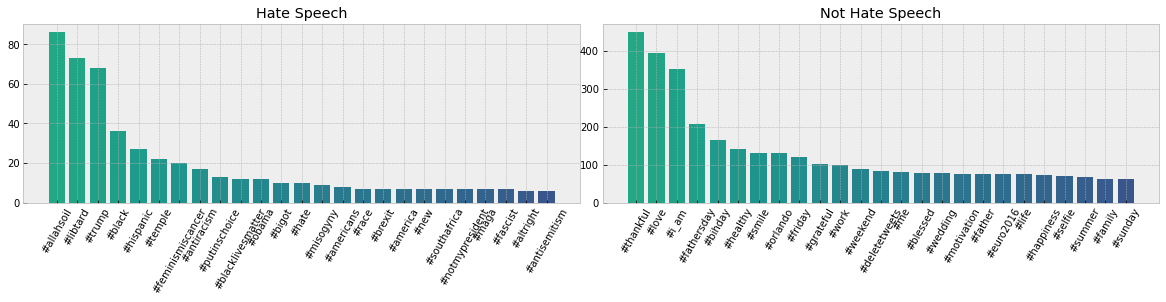

In [86]:
# top 25 hashtags for each label
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)
# generating a bar chart on each axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)

plt.savefig('./visualizations/word count bar graphs.png')
plt.show()

# Word Clouds - Top 25 Hashtags for Each Label

In [88]:
from wordcloud import WordCloud
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

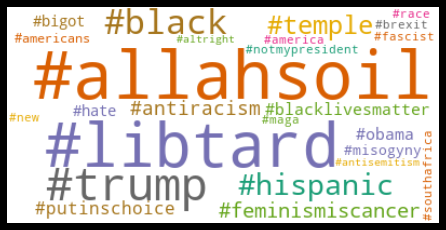

In [90]:
# create the word cloud for hate speech
hate_wordcloud = WordCloud(colormap='Dark2', background_color='white', random_state=16).generate_from_frequencies(hate_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(hate_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.savefig('./visualizations/satire_wordcloud.png')

plt.show()

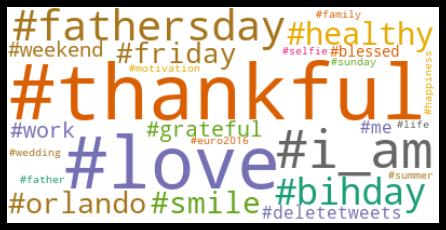

In [91]:
# create the word cloud for NOT hate speech
not_hate_wordcloud = WordCloud(colormap='Dark2', background_color='white', random_state=16).generate_from_frequencies(not_hate_dict)

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(not_hate_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('./visualizations/not_satire_wordcloud.png')

plt.show()

# Joining Word Clouds

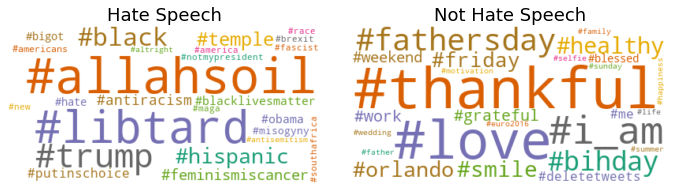

In [93]:
# new figure
f = plt.figure(figsize=(10,8))

# hate speech word cloud
f.add_subplot(1,2, 1)
plt.imshow(hate_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Speech', fontsize=18)

# not hate speech word cloud
f.add_subplot(1,2, 2)
plt.imshow(not_hate_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Hate Speech', fontsize=18)

# setting spacing between graphs
plt.tight_layout(pad=3)

plt.savefig('./visualizations/censored_top_hashtags.png', bbox_inches = "tight", pad_inches=.5)

# Sentiment Analysis with VADER

In [94]:
!pip install vaderSentiment

You should consider upgrading via the 'c:\users\vaish\anaconda3\python.exe -m pip install --upgrade pip' command.

In [96]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [104]:
analyser = SentimentIntensityAnalyzer()

In [105]:
df_sentiments=clean_df
df_sentiments

id  label                                              tweet  \
0          1      0  when a father is dysfunctional and is so selfi...   
1          2      0  thanks for credit i cant use cause they dont o...   
2          3      0                                bihday your majesty   
3          4      0        i love you take with you all the time in ur   
4          5      0                             factsguide society now   
...      ...    ...                                                ...   
31957  31958      0                                 ate isz that youai   
31958  31959      0  to see nina turner on the airwaves trying to w...   
31959  31960      0  listening to sad songs on a monday morning otw...   
31960  31961      1                      vandalised in in condemns act   
31961  31962      0                           thank you for you follow   

      hashtags                                           polarity  
0          NaN  {'neg': 0.402, 'neu': 0.598, 'pos': 0.0, 'comp...  
1          NaN  {'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...  
2          NaN  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3          NaN  {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...  
4          NaN  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
...        ...                                                ...  
31957      NaN  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
31958      NaN  {'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...  
31959      NaN  {'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compou...  
31960      NaN  {'neg': 0.452, 'neu': 0.548, 'pos': 0.0, 'comp...  
31961      NaN  {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...  

[31962 rows x 5 columns]

# Sentiment of Tweets

In [106]:
# function to calculate polarity scores
pol = lambda x: analyser.polarity_scores(x)

In [107]:
# creating new column 'polarity' in clean_df
clean_df['polarity'] = clean_df['tweet'].apply(pol)

In [108]:
# checking that worked
clean_df.head(2)

id  label                                              tweet hashtags  \
0   1      0  when a father is dysfunctional and is so selfi...      NaN   
1   2      0  thanks for credit i cant use cause they dont o...      NaN   

                                            polarity  
0  {'neg': 0.402, 'neu': 0.598, 'pos': 0.0, 'comp...  
1  {'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...

# Parsing Out Polarity Score

In [109]:
# dropping unessential columns
# and seperating out 'polarity' dictionary
df_sentiments = pd.concat([clean_df.drop(['hashtags', 'polarity'], axis=1), clean_df['polarity'].apply(pd.Series)], axis=1)

In [110]:
df_sentiments

id  label                                              tweet    neg  \
0          1      0  when a father is dysfunctional and is so selfi...  0.402   
1          2      0  thanks for credit i cant use cause they dont o...  0.000   
2          3      0                                bihday your majesty  0.000   
3          4      0        i love you take with you all the time in ur  0.000   
4          5      0                             factsguide society now  0.000   
...      ...    ...                                                ...    ...   
31957  31958      0                                 ate isz that youai  0.000   
31958  31959      0  to see nina turner on the airwaves trying to w...  0.000   
31959  31960      0  listening to sad songs on a monday morning otw...  0.360   
31960  31961      1                      vandalised in in condemns act  0.452   
31961  31962      0                           thank you for you follow  0.000   

         neu    pos  compound  
0      0.598  0.000   -0.8296  
1      0.686  0.314    0.6705  
2      1.000  0.000    0.0000  
3      0.704  0.296    0.6369  
4      1.000  0.000    0.0000  
...      ...    ...       ...  
31957  1.000  0.000    0.0000  
31958  0.757  0.243    0.7269  
31959  0.640  0.000   -0.7351  
31960  0.548  0.000   -0.5106  
31961  0.615  0.385    0.3612  

[31962 rows x 7 columns]

# Average Polarity Scores for Each Label

In [111]:
# new dataframe with average polarity score for each label
scores_df = df_sentiments.groupby('label')['pos'].mean().reset_index(name='avg_positive')
scores_df['avg_neutral'] = df_sentiments.groupby('label')['neu'].mean()
scores_df['avg_negative'] = df_sentiments.groupby('label')['neg'].mean()
scores_df['avg_compound'] = df_sentiments.groupby('label')['compound'].mean()

In [112]:
scores_df.head()

label  avg_positive  avg_neutral  avg_negative  avg_compound
0      0      0.172362     0.767617      0.055444      0.158989
1      1      0.093614     0.774321      0.129391     -0.067751

# Interpreting Polarity Scores

# Visualizing Distribution of Each Score

C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


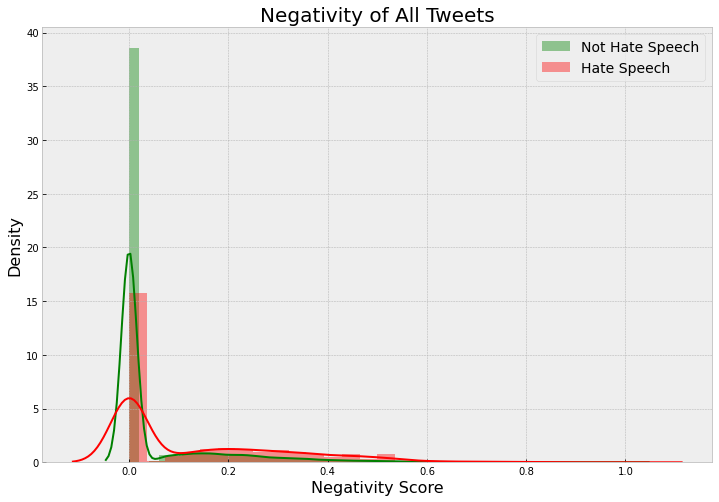

In [113]:
# creating dnsity plot for each label's polarity scores
plt.figure(figsize=(12, 8))
ax = sns.distplot(df_sentiments['neg'][clean_df['label'] == 0], label='Not Hate Speech', color='green')
ax = sns.distplot(df_sentiments['neg'][clean_df['label'] == 1], label='Hate Speech', color='red')
# setting label, title and legend
ax.set_title('Negativity of All Tweets', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Negativity Score', fontsize=16)
ax.legend(prop=dict(size=14))

plt.savefig('./visualizations/negativity_scores.png', bbox_inches = "tight", pad_inches=.5)

C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


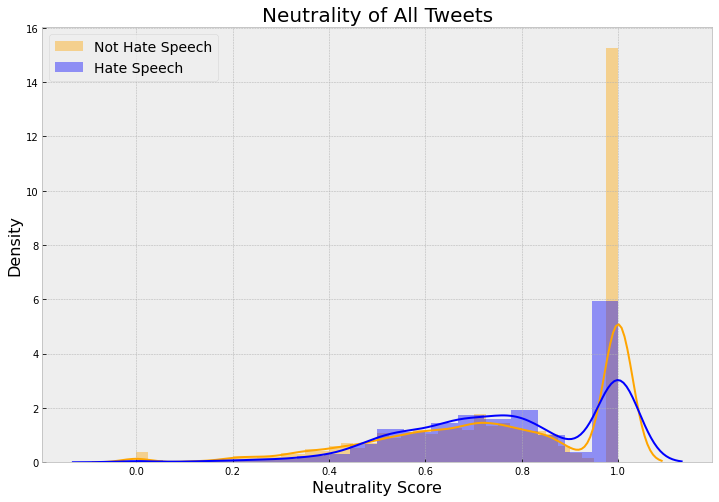

In [114]:
# creating dnsity plot for each label's polarity scores
plt.figure(figsize=(12, 8))
ax = sns.distplot(df_sentiments['neu'][clean_df['label'] == 0], label='Not Hate Speech', color='orange')
ax = sns.distplot(df_sentiments['neu'][clean_df['label'] == 1], label='Hate Speech', color='blue')
# setting label, title and legend
ax.set_title('Neutrality of All Tweets', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Neutrality Score', fontsize=16)
ax.legend(prop=dict(size=14))

plt.savefig('./visualizations/neutrality_scores.png', bbox_inches = "tight", pad_inches=.5)

C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


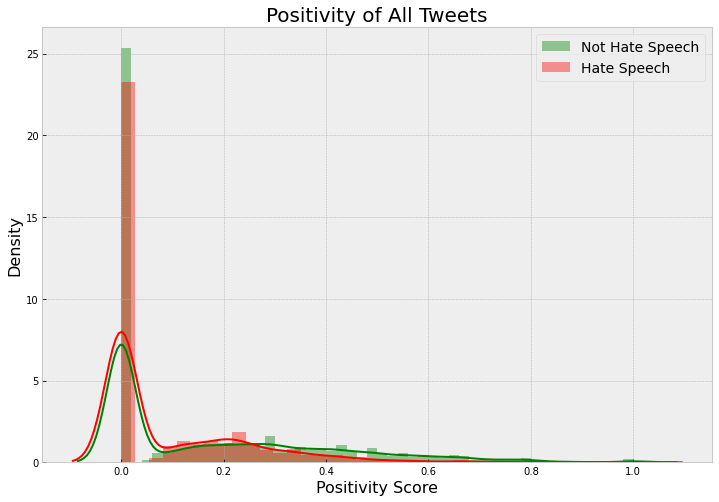

In [115]:
# creating dnsity plot for each label's polarity scores
plt.figure(figsize=(12, 8))
ax = sns.distplot(df_sentiments['pos'][clean_df['label'] == 0], label='Not Hate Speech', color='green')
ax = sns.distplot(df_sentiments['pos'][clean_df['label'] == 1], label='Hate Speech', color='red')
# setting label, title and legend
ax.set_title('Positivity of All Tweets', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Positivity Score', fontsize=16)
ax.legend(prop=dict(size=14))

plt.savefig('./visualizations/positivity_scores.png', bbox_inches = "tight", pad_inches=.5)

C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


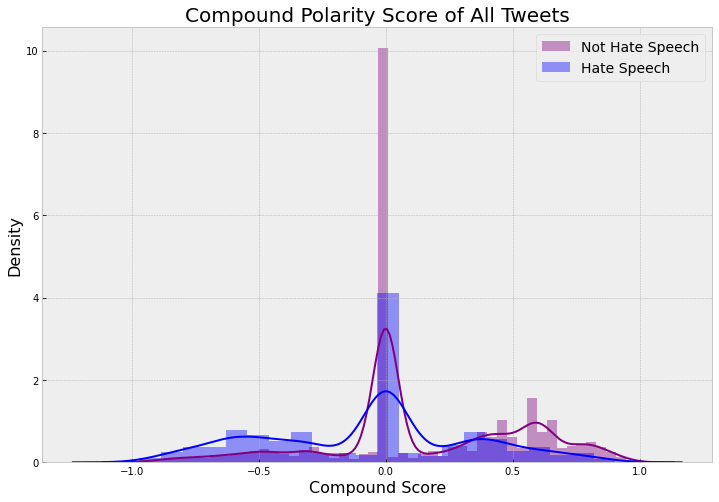

In [116]:
# creating dnsity plot for each label's polarity scores
plt.figure(figsize=(12, 8))
ax = sns.distplot(df_sentiments['compound'][clean_df['label'] == 0], label='Not Hate Speech', color='purple')
ax = sns.distplot(df_sentiments['compound'][clean_df['label'] == 1], label='Hate Speech', color='blue')
# setting label, title and legend
ax.set_title('Compound Polarity Score of All Tweets', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Compound Score', fontsize=16)
ax.legend(prop=dict(size=14))

plt.savefig('./visualizations/compound_polarity_score.png', bbox_inches = "tight", pad_inches=.5)

# Bar Chart of Sentiment Scores by Tweet Type

In [117]:
# function to add percentage above each polarity score
def autolabel(rects):
    """Add a text label above bars to display its perentage of data."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3}'.format(height * 100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

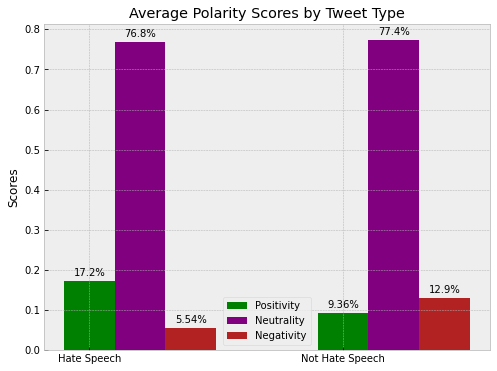

In [118]:
# setting labls and average scores
labels = ['Hate Speech', 'Not Hate Speech']
all_positivity = df_sentiments['pos'].groupby(df_sentiments['label']).mean()
all_neutrality = df_sentiments['neu'].groupby(df_sentiments['label']).mean()
all_negativity = df_sentiments['neg'].groupby(df_sentiments['label']).mean()

# set width of bars
width = 0.2  # the width of the bars
# set position of bar on x-axis
x = np.arange(len(labels))
r1 = x
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

# graph figure
fig, ax = plt.subplots(figsize=(8, 6))
# 3 types of grouped bar graphs
ax1 = ax.bar(r1, all_positivity, width, label='Positivity', color='green')
ax2 = ax.bar(r2, all_neutrality, width, label='Neutrality', color='purple')
ax3 = ax.bar(r3, all_negativity, width, label='Negativity', color='firebrick')

# applying percentage display function
autolabel(ax1)
autolabel(ax2)
autolabel(ax3)

# setting axis labels, title and legend location
ax.set_ylabel('Scores')
ax.set_title('Average Polarity Scores by Tweet Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.savefig('./visualizations/avg_polarity_by_tweet_type.png', bbox_inches = "tight", pad_inches=.5)

# Checking Class Imbalance of Original Data's Labels

C:\Users\vaish\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


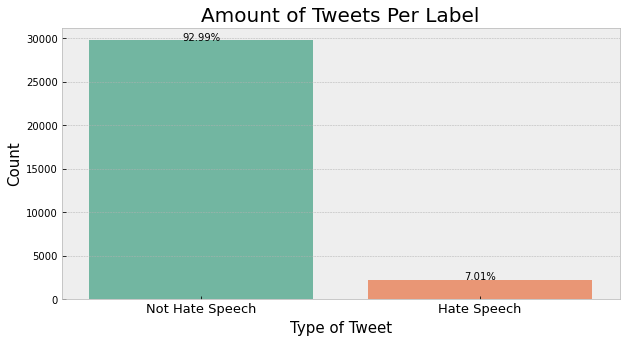

In [119]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['label'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig('./visualizations/cleaned_class_imbalance.png', bbox_inches = "tight", pad_inches=.5)